# SHAP 101 - explaining ml models and beyond

### Feature Attributions
* SHAP (SHapley Additive exPlanations) - https://shap.readthedocs.io/en/latest/
* Understand individual predictions - https://www.kaggle.com/code/dansbecker/shap-values/tutorial
* Aggregate SHAP values for even more detailed model insights - https://www.kaggle.com/code/dansbecker/advanced-uses-of-shap-values/tutorial

* Convert SHAP Score to percentage: https://medium.com/towards-data-science/* black-box-models-are-actually-more-explainable-than-a-logistic-regression-f263c22795d

### Partial Dependence Plot
* Partial Dependence Plot Theory - https://christophm.github.io/interpretable-ml-book/pdp.html
* Partial Dependence Plots - https://scikit-learn.org/stable/modules/partial_dependence.html

### Additional References
* Fairlearn - https://fairlearn.org
* squaredev.io - https://github.com/squaredev-io/explainable-ai
* Rerun-sdk - https://pypi.org/project/rerun-sdk/

### Pandas 
* Working with missing value - https://pandas.pydata.org/docs/user_guide/missing_data.html
* show max columns - https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe/11711637#11711637

# Kaggle Titanic Compitition
https://www.kaggle.com/competitions/titanic

### Data Description
https://www.kaggle.com/competitions/titanic/data?select=train.csv

| Variable | Definition	| Key | 
| :--- | :--- | :--- |
| survival | Survival |	0 = No, 1 = Yes |
| pclass   | Ticket class |	1 = 1st, 2 = 2nd, 3 = 3rd |
| sex |	Sex	| |
| Age |	Age | in years | 	
| sibsp	| # of siblings / spouses aboard the Titanic |	
| parch	| # of parents / children aboard the Titanic |	
| ticket |	Ticket number | |	
| fare | Passenger fare | (Y.W.: Ticket price paid)  |	
| cabin	| Cabin number | |	
| embarked	| Port of Embarkation |	C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes

**pclass:** A proxy for socio-economic status (SES)
* 1st = Upper
* 2nd = Middle
* 3rd = Lower

**age:** Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp:** The dataset defines family relations in this way...
* Sibling = brother, sister, stepbrother, stepsister
* Spouse = husband, wife (mistresses and fiancés were ignored)

**parch:** The dataset defines family relations in this way...
* Parent = mother, father
* Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

In [138]:
# graphic display mode
DARK_MODE = True

In [139]:
from utils.util import (
    KaggleData, 
    current_dir_subpath, 
    na_columns_mask, 
    profile, 
    feature_correlation, 
    na_columns,
    fill_missing_values_with_mean,
)
import pandas as pd
pd.set_option('display.max_columns', 10)

titanic_train_path = current_dir_subpath("data/train.csv")
titanic_test_path = current_dir_subpath("data/test.csv")
label_name = "Survived"
one_hot_cols = ["Sex"]

titanic = KaggleData(
     train_path = titanic_train_path,
     test_path = titanic_test_path,
     label_col=label_name
)

train_X_df, test_X_df, train_y = titanic.load(one_hot_cols=one_hot_cols)
all_X_df = titanic.load_all(one_hot_cols=one_hot_cols)

## Explore numerical features in different data sets

In [140]:
num_features = all_X_df.describe().columns.to_list()
print(num_features)

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']


In [141]:
profile(train_X_df, title="Profile Training Dataset")
print("#" * 20)
profile(test_X_df, title="Profile Test Dataset")

Profile Training Dataset
Shape: (891, 12)
Numerical Columns: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']
No. of NaN in Num. Cols: 177
       PassengerId      Pclass         Age       SibSp       Parch        Fare  Sex_female    Sex_male
count   891.000000  891.000000  714.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean    446.000000    2.308642   29.699118    0.523008    0.381594   32.204208    0.352413    0.647587
std     257.353842    0.836071   14.526497    1.102743    0.806057   49.693429    0.477990    0.477990
min       1.000000    1.000000    0.420000    0.000000    0.000000    0.000000    0.000000    0.000000
25%     223.500000    2.000000   20.125000    0.000000    0.000000    7.910400    0.000000    0.000000
50%     446.000000    3.000000   28.000000    0.000000    0.000000   14.454200    0.000000    1.000000
75%     668.500000    3.000000   38.000000    1.000000    0.000000   31.000000    1.000000    1.000000
m

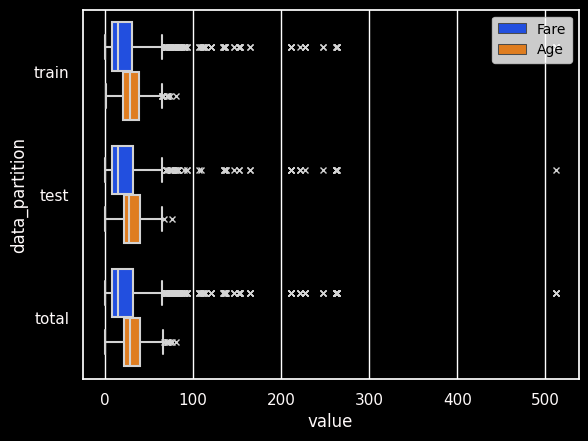

In [142]:
# titanic.boxplot_dist(["PassengerId", "Fare", "Age"], marker="x", orient="h", legend="upper right", dark_mode=DARK_MODE)
titanic.boxplot_dist(["Fare", "Age"], marker="x", orient="h", legend="upper right", dark_mode=DARK_MODE)

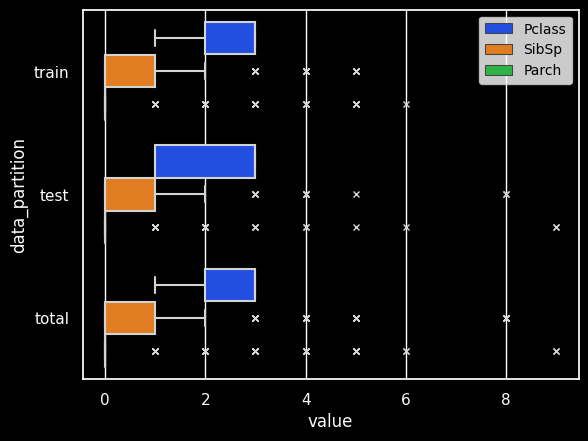

In [143]:
titanic.boxplot_dist(['Pclass', 'SibSp', 'Parch'], marker="x", orient="h", legend="upper right", dark_mode=DARK_MODE)

In [144]:
# data_X_df.dtypes

## Examining the correlation of numerical features and labels

In [145]:
train_df = pd.concat([train_X_df, train_y], axis=1)
threshold = 0.2
corr_df, high_corr_df = feature_correlation(train_df, label=label_name, threshold=threshold)
corr_df


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Survived
PassengerId,1.000000,-0.035144,0.036847,-0.057527,-0.001652,0.012658,-0.042939,0.042939,-0.005007
Pclass,-0.035144,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.131900,0.131900,-0.338481
Age,0.036847,-0.369226,1.000000,-0.308247,-0.189119,0.096067,-0.093254,0.093254,-0.077221
SibSp,-0.057527,0.083081,-0.308247,1.000000,0.414838,0.159651,0.114631,-0.114631,-0.035322
Parch,-0.001652,0.018443,-0.189119,0.414838,1.000000,0.216225,0.245489,-0.245489,0.081629
Fare,0.012658,-0.549500,0.096067,0.159651,0.216225,1.000000,0.182333,-0.182333,0.257307
Sex_female,-0.042939,-0.131900,-0.093254,0.114631,0.245489,0.182333,1.000000,-1.000000,0.543351
Sex_male,0.042939,0.131900,0.093254,-0.114631,-0.245489,-0.182333,-1.000000,1.000000,-0.543351
Survived,-0.005007,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.543351,-0.543351,1.000000


In [146]:
high_corr_df

,Survived
Pclass,-0.338481
Fare,0.257307
Sex_female,0.543351
Sex_male,-0.543351
Survived,1.000000


In [147]:
train_X_df.head()

,PassengerId,Pclass,Name,Age,SibSp,...,Fare,Cabin,Embarked,Sex_female,Sex_male
0,1,3,"Braund, Mr. Owen Harris",22.0,1,...,7.2500,NaN,S,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,...,71.2833,C85,C,1,0
2,3,3,"Heikkinen, Miss. Laina",26.0,0,...,7.9250,NaN,S,1,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,...,53.1000,C123,S,1,0
4,5,3,"Allen, Mr. William Henry",35.0,0,...,8.0500,NaN,S,0,1


In [148]:
all_X_df.columns[na_columns_mask(all_X_df)].to_list()

['Age', 'Fare', 'Cabin', 'Embarked']

In [149]:
print(test_X_df.isna().any(axis=0))

PassengerId    False
Pclass         False
Name           False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
Sex_female     False
Sex_male       False
dtype: bool


## Data Inputation

replace the na of numerical features in training dataset

In [150]:
train_X_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208,0.352413,0.647587
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429,0.477990,0.477990
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000


In [151]:
test_X_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000,418.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188,0.363636,0.636364
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576,0.481622,0.481622
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200,0.000000,1.000000
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000,1.000000,1.000000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200,1.000000,1.000000


In [152]:
all_X_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,1309.000000,1309.000000
mean,655.000000,2.294882,29.881138,0.498854,0.385027,33.295479,0.355997,0.644003
std,378.020061,0.837836,14.413493,1.041658,0.865560,51.758668,0.478997,0.478997
min,1.000000,1.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,328.000000,2.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000
50%,655.000000,3.000000,28.000000,0.000000,0.000000,14.454200,0.000000,1.000000
75%,982.000000,3.000000,39.000000,1.000000,0.000000,31.275000,1.000000,1.000000
max,1309.000000,3.000000,80.000000,8.000000,9.000000,512.329200,1.000000,1.000000


In [153]:
def filter_values(x):
    """x is tuple with two positions"""
    match x[0]:
        case "Age":
            return (x[0], round(x[1]))
        case "Fare":
            return (x[0], round(x[1], 4)) # returns float with rounded 4 decimals
        case _:
            return x      

In [154]:
train_X_df, train_mean_dict = fill_missing_values_with_mean(
    df=train_X_df, pop_df=all_X_df, filter_cols=num_features, filter_func=filter_values)
print(train_mean_dict)
print(f"num of numerical cols. has NaN values: {len(na_columns(train_X_df, num_features))}")

{'Age': 30}
num of numerical cols. has NaN values: 0


In [155]:
test_X_df, test_mean_dict = fill_missing_values_with_mean(
    df=test_X_df, pop_df=all_X_df, filter_cols=num_features, filter_func=filter_values)
print(test_mean_dict)
print(f"num of numerical cols. has NaN values: {len(na_columns(test_X_df, num_features))}")


{'Age': 30, 'Fare': 33.2955}
num of numerical cols. has NaN values: 0


In [156]:
profile(df=train_X_df)


Shape: (891, 12)
Numerical Columns: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']
No. of NaN in Num. Cols: None
       PassengerId      Pclass         Age       SibSp       Parch        Fare  Sex_female    Sex_male
count   891.000000  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean    446.000000    2.308642   29.758889    0.523008    0.381594   32.204208    0.352413    0.647587
std     257.353842    0.836071   13.002570    1.102743    0.806057   49.693429    0.477990    0.477990
min       1.000000    1.000000    0.420000    0.000000    0.000000    0.000000    0.000000    0.000000
25%     223.500000    2.000000   22.000000    0.000000    0.000000    7.910400    0.000000    0.000000
50%     446.000000    3.000000   30.000000    0.000000    0.000000   14.454200    0.000000    1.000000
75%     668.500000    3.000000   35.000000    1.000000    0.000000   31.000000    1.000000    1.000000
max     891.000000    3.

In [157]:
profile(df=test_X_df)


Shape: (418, 12)
Numerical Columns: ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex_female', 'Sex_male']
No. of NaN in Num. Cols: None
       PassengerId      Pclass         Age       SibSp       Parch        Fare  Sex_female    Sex_male
count   418.000000  418.000000  418.000000  418.000000  418.000000  418.000000  418.000000  418.000000
mean   1100.500000    2.265550   30.216507    0.447368    0.392344   35.621610    0.363636    0.636364
std     120.810458    0.841838   12.635016    0.896760    0.981429   55.840617    0.481622    0.481622
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   23.000000    0.000000    0.000000    7.895800    0.000000    0.000000
50%    1100.500000    3.000000   30.000000    0.000000    0.000000   14.454200    0.000000    1.000000
75%    1204.750000    3.000000   35.750000    1.000000    0.000000   31.500000    1.000000    1.000000
max    1309.000000    3.

## Model: naiv gender based

In [158]:
train_df 

,PassengerId,Pclass,Name,Age,SibSp,...,Cabin,Embarked,Sex_female,Sex_male,Survived
0,1,3,"Braund, Mr. Owen Harris",22.0,1,...,NaN,S,0,1,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,...,C85,C,1,0,1
2,3,3,"Heikkinen, Miss. Laina",26.0,0,...,NaN,S,1,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,...,C123,S,1,0,1
4,5,3,"Allen, Mr. William Henry",35.0,0,...,NaN,S,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",27.0,0,...,NaN,S,0,1,0
887,888,1,"Graham, Miss. Margaret Edith",19.0,0,...,B42,S,1,0,1
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,1,...,NaN,S,1,0,0
889,890,1,"Behr, Mr. Karl Howell",26.0,0,...,C148,C,0,1,1


In [159]:
women = train_df.loc[train_df["Sex_female"] == 1]["Survived"]
rate_women = sum(women) / len(women)

print(f"% of women who survied: {rate_women:.2%}")

% of women who survied: 74.20%
